## Setup

In [1]:
!pip install poetry

In [2]:
!pip install https://github.com/swanandlab/SMorph/releases/download/v0.1.1-alpha/SMorph-0.1.1.tar.gz

In [3]:
on_colab = 'google.colab' in str(get_ipython())

if not on_colab:
    import napari
import smorph.util.autocrop as ac

import warnings
warnings.filterwarnings('ignore')

In [4]:
def view_3D(*args):  # Models a 3D image
    n_images = len(args)
    if not on_colab and n_images > 0:
        with napari.gui_qt():
            viewer = napari.view_image(**args[0])
            for itr in range(1, n_images):
                viewer.add_image(**args[itr])

## 1. Import Confocal Microscopic Image of the Tissue

Set `CONFOCAL_TISSUE_IMAGE` to the path of the image file to be processed.
- Followed by non-local means denoising using auto-calibrated parameters

{'h': 0.0319707041900338, 'patch_size': 2, 'patch_distance': 2}


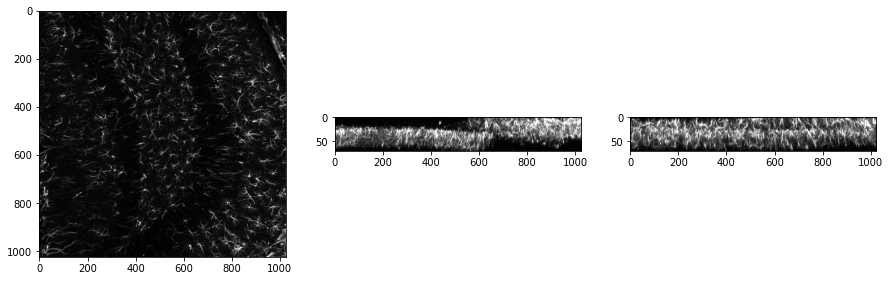

In [5]:
CONFOCAL_TISSUE_IMAGE = 'Datasets/SECTION 1_M1_LEFT/M1_LEFT _HILUS.lsm'

original = ac.import_confocal_image(CONFOCAL_TISSUE_IMAGE)

denoiser = ac.calibrate_nlm_denoiser(original)
denoise_parameters = denoiser.keywords['denoiser_kwargs']
print(denoise_parameters)
denoised = ac.denoise(original, denoise_parameters)
ac.projectXYZ(denoised, .5, .5, 1)

In [6]:
view_3D({'data': original, 'colormap': 'gray', 'name': 'original'},
        {'data': denoised, 'colormap': 'inferno', 'name': 'denoised'})

## 2. Select ROI using Polygonal Lasso Tool

Set two variables:
- `SELECT_ROI`: True, If you want to select ROI manually; else False
- `NAME_ROI`: Name of the manually selected ROI

In [7]:
SELECT_ROI = True
NAME_ROI = 'Hilus'
FILE_ROI = 'Results/M1_LEFT _HILUS-Hilus.roi'

%matplotlib widget
NAME_ROI = NAME_ROI if SELECT_ROI else ''
IMG_NAME = CONFOCAL_TISSUE_IMAGE.split('/')[-1].split('.')[0]
linebuilder = None if not SELECT_ROI else ac.select_ROI(denoised, IMG_NAME + '-' + NAME_ROI, FILE_ROI)

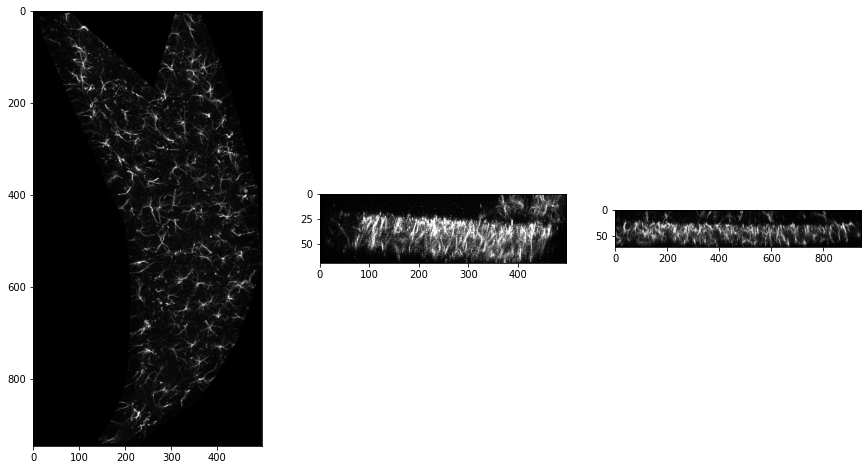

In [8]:
%matplotlib inline
if SELECT_ROI:
    original, denoised = ac.mask_ROI(original, denoised, linebuilder)
    ac.projectXYZ(denoised, .5, .5, 1)

## 3. Segmentation

### 3.1 Threshold & color label cells

Set two parameters:
- `LOW_THRESH`: Pixel intensity value corresponding to faintest branch's edge
- `HIGH_THRESH`: Pixel intensity value corresponding to faintest soma

Understand their effect by configuring three parameters:
- `LOW_DELTA`: Pixel intensity value corresponding to change in `LOW_THRESH`
- `HIGH_DELTA`: Pixel intensity value corresponding to change in `HIGH_THRESH`
- `N_STEPS`: Number of steps of delta in threshold to take in both directions

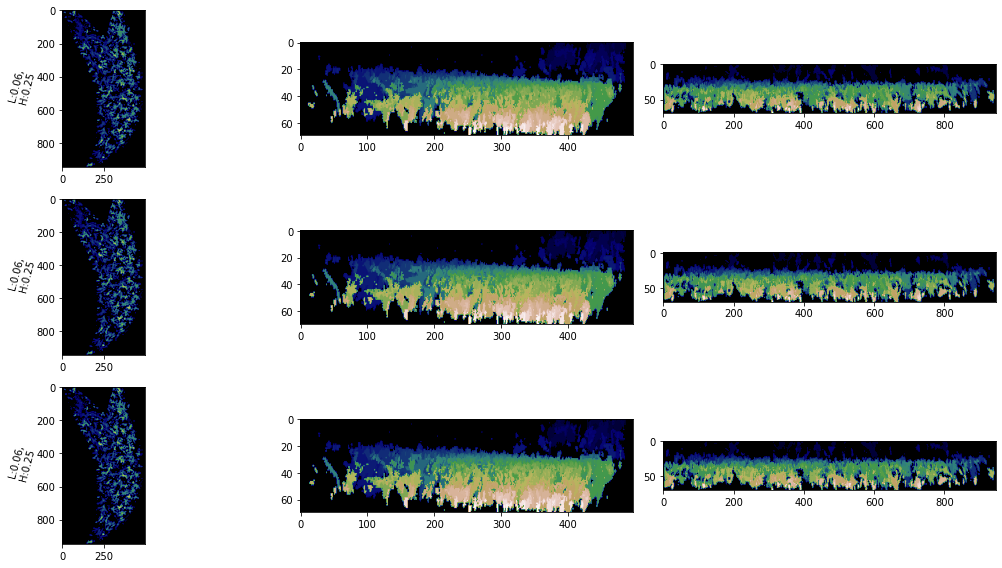

In [9]:
LOW_THRESH = .06
HIGH_THRESH = .25

LOW_DELTA = .0025
HIGH_DELTA = .00
N_STEPS = 1

results = ac.testThresholds(denoised, .5, .5, 1, 'gist_earth',
                            LOW_THRESH, HIGH_THRESH, LOW_DELTA, HIGH_DELTA, N_STEPS)
view_3D({'data': denoised, 'colormap': 'inferno', 'name': 'denoised'}, *results)

Thresholding results

In [10]:
thresholded = ac.threshold(denoised, LOW_THRESH, HIGH_THRESH)
labels = ac.label_thresholded(thresholded)

### 3.2 Filter segmented individual cells by removing ones in borders (touching the convex hull)

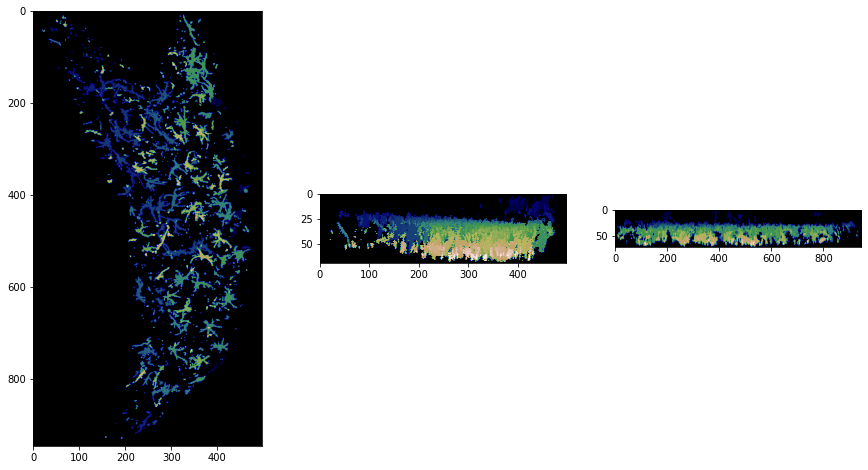

In [11]:
# discard objects connected to border of approximated tissue, potential partially captured
filtered_labels = ac.filter_labels(labels, thresholded, linebuilder)
ac.projectXYZ(filtered_labels, .5, .5, 1, 'gist_earth')

In [12]:
view_3D({'data': filtered_labels, 'colormap': 'gray', 'gamma': .8, 'name': 'filtered_labels'},
        {'data': labels, 'colormap': 'gist_earth', 'name': 'labels'})

In [13]:
# get the centroids and label values from the label image
regions = ac.arrange_regions(filtered_labels)
centroid_coords = [r.centroid for r in regions]

# store the labels for each blob in a properties dictionary
pts_properties = {'obj': [i for i in range(len(regions))]}

### 3.3 Visualize segmented cells to determine cutoff volumes

#### 3.3.1 Check segmented cells on whole image

In [21]:
if not on_colab:
    with napari.gui_qt():
        viewer = napari.view_image(denoised, name='denoised')
        viewer.add_labels(filtered_labels, name='filtered_labels')
        viewer.add_points(centroid_coords, edge_color='transparent',
                          face_color='transparent',
                          properties=pts_properties, text='obj')

#### 3.3.2 Check batches of objects

In [15]:
N_BATCHES = ac.paginate_objs(regions, pg_size=50)

945 objects detected.
There will be 19 batches, set `BATCH_NO` from 0 to 18 inclusive


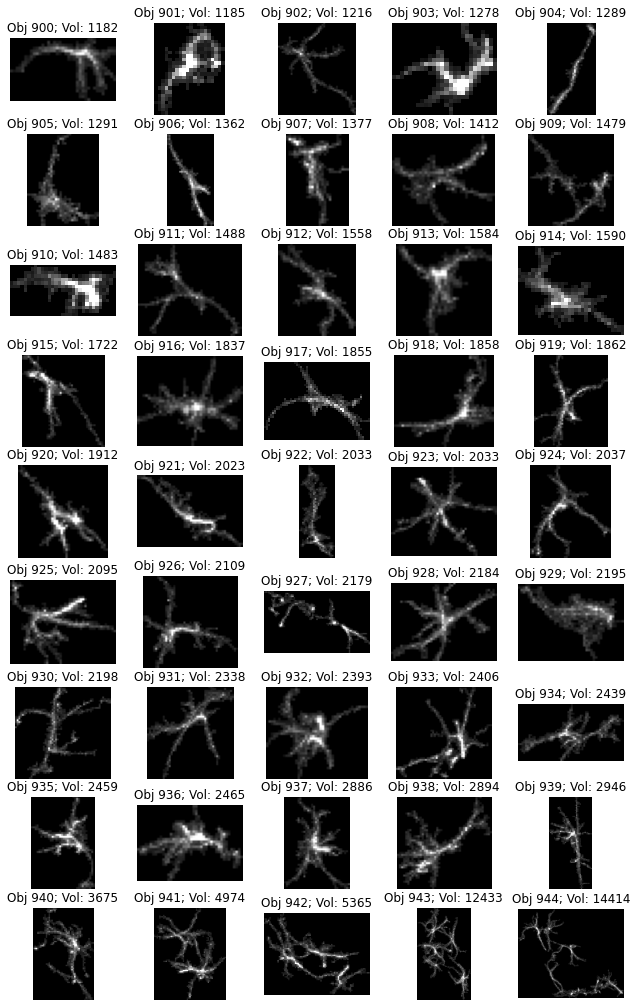

In [23]:
# Set `BATCH_NO` to view detected objects in paginated 2D MIP views.
BATCH_NO = 18
ac.project_batch(BATCH_NO, N_BATCHES, regions, denoised)

#### 3.3.2 Check individual objects
Select individual objects using `OBJ_INDEX`.

Volume of this object is: 2


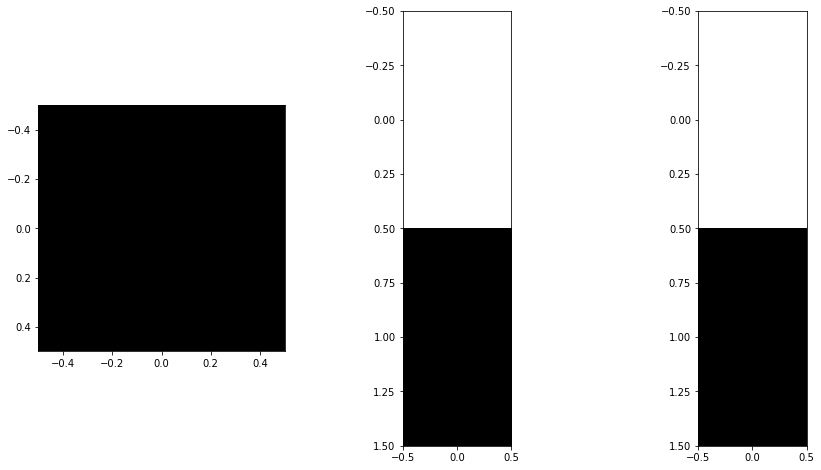

(32, 759, 339, 34, 760, 340)

In [17]:
OBJ_INDEX = 199

extracted_cell = ac.extract_obj(regions[OBJ_INDEX], denoised)
minz, miny, minx, maxz, maxy, maxx = regions[OBJ_INDEX].bbox
ac.projectXYZ(extracted_cell, .5, .5, 1)
minz, miny, minx, maxz, maxy, maxx

In [18]:
view_3D({'data': denoised[minz:maxz, miny:maxy, minx:maxx], 'name': 'denoised'},
        {'data': regions[OBJ_INDEX].image, 'colormap': 'yellow', 'name': 'thresholded'},
        {'data': extracted_cell, 'colormap': 'inferno', 'name': 'extracted_cell'})

## 4. Export autocropped 3D cells or 2D max intensity projections

Set two parameters:
- `LOW_VOLUME_CUTOFF`: to filter out noise/artifacts
- `HIGH_VOLUME_CUTOFF`: to filter out cell clusters

For choosing between 3D segmented cells or 2D max intensity projections:
- Set `OUTPUT_OPTION` = '3d' for 3D cells, or
- Set `OUTPUT_OPTION` = 'mip' for Max Intensity Projections.

In [19]:
LOW_VOLUME_CUTOFF = 1101  # filter noise/artifacts
HIGH_VOLUME_CUTOFF = 3133  # filter cell clusters

OUTPUT_OPTION = 'mip'  # '3d' for 3D cells, 'mip' for Max Intensity Projections
SEGMENT_TYPE = 'segmented'

ac.export_cells(CONFOCAL_TISSUE_IMAGE, LOW_VOLUME_CUTOFF,
                HIGH_VOLUME_CUTOFF, OUTPUT_OPTION, denoised,
                regions, SEGMENT_TYPE, NAME_ROI, linebuilder)